# DeepDream


**DeepDream** is an experiment that visualizes the patterns learned by a neural network. Similar to when a child watches clouds and tries to interpret random shapes, DeepDream over-interprets and enhances the patterns it sees in an image.

It does so by forwarding an image through the network, then calculating the gradient of the image with respect to the activations of a particular layer. The image is then modified to increase these activations, enhancing the patterns seen by the network, and resulting in a dream-like image. This process was dubbed "Inceptionism" (a reference to [InceptionNet](https://arxiv.org/pdf/1409.4842.pdf), and the [movie](https://en.wikipedia.org/wiki/Inception) Inception).
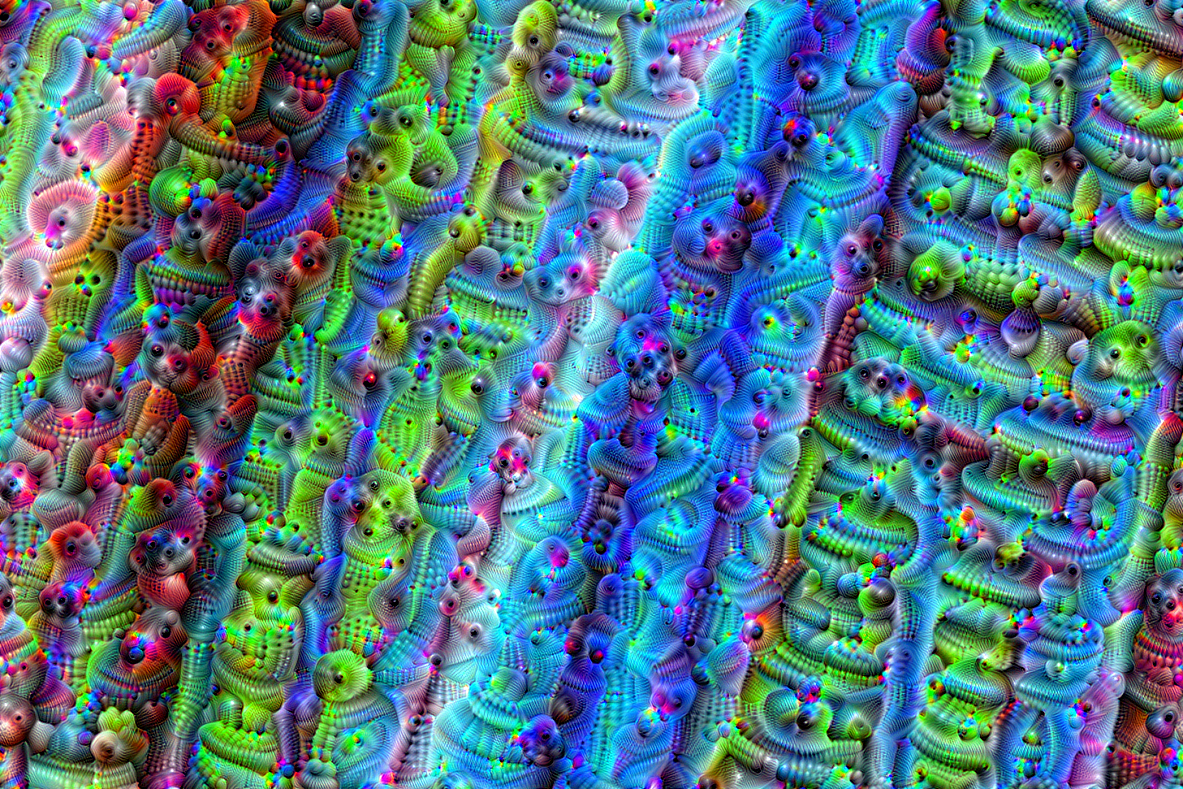
Let's demonstrate how you can make a neural network "dream" and enhance the surreal patterns it sees in an image.


## Imports

In [ ]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from imageio import mimsave
import matplotlib as mpl

from IPython.display import display,Image,clear_output
import PIL.Image

## Choose an image to dream-ify

In [ ]:
# You can either choose to import an image or her's a URL of a Labrador Image
# url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
path = '/content/golden_retriever_dog_is_standing_on_algae_covered_rock_in_blur_forest_background_hd_dog.jpg'

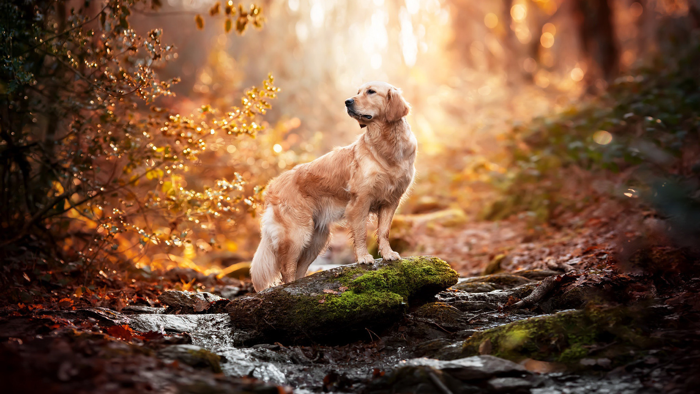

In [ ]:
# Download an image and read it into a NumPy array.
def download(image_path=path, max_dim=None):
  # name = url.split('/')[-1]
  # image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(max_dim=700)
show(original_img)

## Prepare the feature extraction model

Download and prepare a pre-trained image classification model. You will use [InceptionV3](https://keras.io/api/applications/inceptionv3/) which is similar to the model originally used in DeepDream. Note that any [pre-trained model](https://keras.io/api/applications/#available-models) will work, although you will have to adjust the layer names below if you change this.

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

The idea in DeepDream is to choose a layer (or layers) and maximize the "loss" in a way that the image increasingly "excites" the layers. The complexity of the features incorporated depends on layers chosen by you, i.e, lower layers produce strokes or simple patterns, while deeper layers give sophisticated features in images, or even whole objects.

In [ ]:
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

## Gradient ascent

Once you have calculated the loss for the chosen layers, all that is left is to calculate the gradients with respect to the image, and add them to the original image.

Adding the gradients to the image enhances the patterns seen by the network. At each step, you will have created an image that increasingly excites the activations of certain layers in the network.

The method that does this, below, is wrapped in a `tf.function` for performance. It uses an `input_signature` to ensure that the function is not retraced for different image sizes or `steps`/`step_size` values. See the [Concrete functions guide](../../guide/function.ipynb) for details.

In [ ]:
class DreamModel(tf.Module):
  def __init__(self, model, img):
    self.model = model
    self.img = img
    # preprocessing of the image to be fed into
    self.img = tf.keras.applications.inception_v3.preprocess_input(self.img)
    self.img = tf.convert_to_tensor(self.img)
    self.gen_images = []


  # @tf.function(
  #     input_signature=(
  #       tf.TensorSpec(shape=[], dtype=tf.int32),
  #       tf.TensorSpec(shape=[], dtype=tf.float32),)
  # )
  def __call__(self, steps, step_size):
      print("Tracing...")
      step_size = tf.convert_to_tensor(step_size)
      step_size = tf.constant(step_size)
      loss = tf.constant(0.0)

      for n in tqdm(range(steps)):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(self.img)
          loss = self.calc_loss()

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, self.img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8

        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        self.img = self.img + gradients*step_size
        self.img = tf.clip_by_value(self.img, -1, 1)

        if n % 100 == 0:
          clear_output(wait=True)
          show(deprocess(self.img))
          print("\nStep {}, loss {:.5f}".format(n, loss))
          self.gen_images.append(self.img)

        clear_output(wait=True)
        show(deprocess(self.img))
        print ("Step {}, loss {:.5f}".format(n, loss))
        self.gen_images.append(self.img)

  def calc_loss(self):
    # Pass forward the image through the model to retrieve the activations.
    # Converts the image into a batch of size 1.
    img_batch = tf.expand_dims(self.img, axis=0)
    layer_activations = self.model(img_batch)
    if len(layer_activations) == 1:
      layer_activations = [layer_activations]

    losses = []
    for act in layer_activations:
      loss = tf.math.reduce_mean(act)
      losses.append(loss)

    return  tf.reduce_sum(losses)

# Instantiate Model
DeepDream = DreamModel(dream_model,original_img)

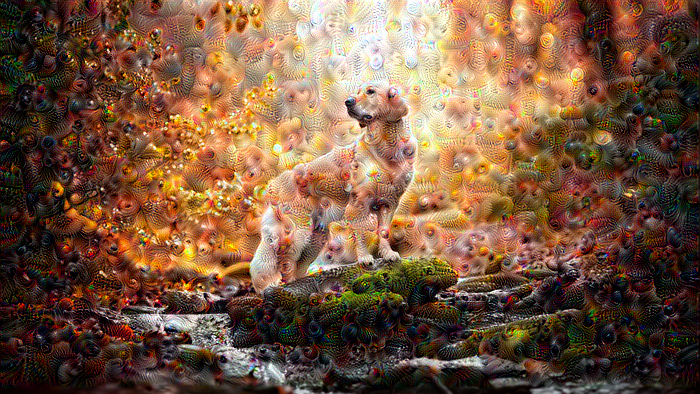

100%|██████████| 100/100 [00:37<00:00,  2.65it/s]

Step 99, loss 2.57499


In [ ]:
DeepDream(100,0.01)

## Save Gen Images GIF

In [ ]:
gif_path = '/content/animation.gif'  # path for the GIF file
image_list = [deprocess(x).numpy() for x in DeepDream.gen_images]
mimsave(gif_path, image_list, duration=0.7)

# Display the GIF
try:
  display(display.Image(filename=gif_path))
except:
  pass

$$$$

$$$$

## Taking it up an octave

Pretty good, but there are a few issues with this first attempt:

  1. The output is noisy (this could be addressed with a `tf.image.total_variation` loss).
  1. The image is low resolution.
  1. The patterns appear like they're all happening at the same granularity.
  
One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

To do this you can perform the previous gradient ascent approach, then increase the size of the image (which is referred to as an octave), and repeat this process for multiple octaves.


## Scaling up with tiles

One thing to consider is that as the image increases in size, so will the time and memory necessary to perform the gradient calculation. The above octave implementation will not work on very large images, or many octaves.

To avoid this issue you can split the image into tiles and compute the gradient for each tile.

Applying random shifts to the image before each tiled computation prevents tile seams from appearing.

Start by implementing the random shift:

In [ ]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

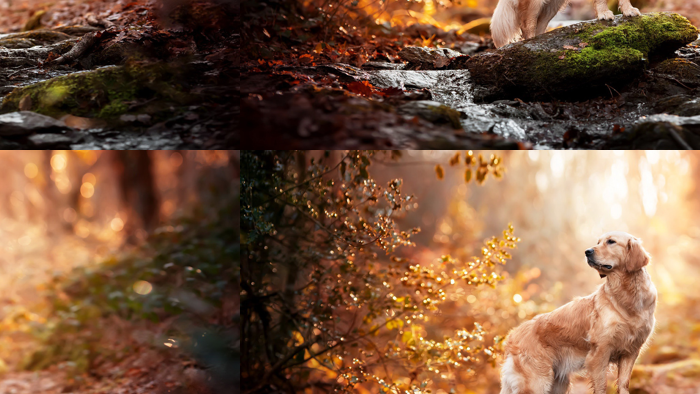

In [ ]:
img_rolled = tf.roll(original_img, shift=np.array([150,120]), axis=[0,1])
img_rolled = tf.roll(img_rolled, shift=np.array([0,120]), axis=[0,1])
show(img_rolled)

Here is a tiled equivalent of the `deepdream` function defined earlier:

In [ ]:
tile_size = 512
shift, img_rolled = random_roll(original_img, tile_size)

# Initialize the image gradients to zero.
gradients = tf.zeros_like(img_rolled)
img_size = img_rolled.shape
img_size

TensorShape([394, 700, 3])

In [ ]:
# Skip the last tile, unless there's only one tile.
xs = tf.range(0, img_size[1], tile_size)[:-1]
if not tf.cast(len(xs), bool):
  xs = tf.constant([0])
ys = tf.range(0, img_size[0], tile_size)[:-1]
if not tf.cast(len(ys), bool):
  ys = tf.constant([0])
xs,ys

(<tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>)

In [ ]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8

    return gradients

In [ ]:
get_tiled_gradients = TiledGradients(dream_model)

Putting this together gives a scalable, octave-aware deepdream implementation:

In [ ]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01,
                                octaves=range(-2,3), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))

  result = deprocess(img)
  return result

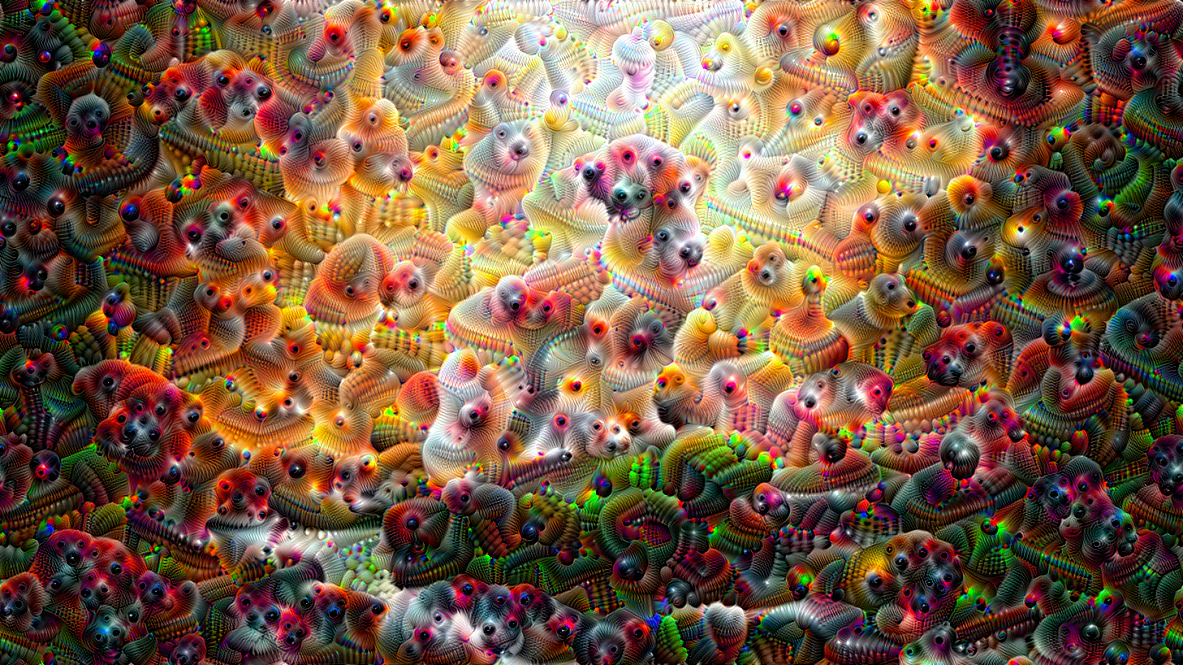

Octave 2, Step 90


In [ ]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

Much better! Play around with the number of octaves, octave scale, and activated layers to change how your DeepDream-ed image looks.

Readers might also be interested in [TensorFlow Lucid](https://github.com/tensorflow/lucid) which expands on ideas introduced in this tutorial to visualize and interpret neural networks.